### ТЕСТОВОЕ ЗАДАНИЕ
- Необходимо реализовать модель на основе данного датасета
- Для достижения данной цели нужно обработать датасет, привести его в вид, готовый для обучения с помощью модели МЛ (выбор модели зависит только от вас, ограничений на это нет)
#### Требования:
- Python script/ Python Jupyter notebook
#### Материалы:
- Ссылка на датасет: https://drive.google.com/file/d/1lL9XWBR_3F4xozizi0aOEfrI-VqqNcKw/view?usp=sharing
#### Описание датасета:
- Датасет описывает некоторую зависимость числа `bugs` от значений `repository_name`, `commit_hash`, `commit_date`, `commit_author`, `commit_message`. Вам необходимо выявить данную зависимость и написать скрипт/ноутбук, обучающий модель по данному датасету<br>

Готовый проект выложить на GitHub и прислать ссылку

In [70]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import eli5
import os
import warnings
warnings.filterwarnings('ignore')

In [71]:
PATH = ''
SEED = 42

Загрузка данных

In [72]:
df = pd.read_csv(os.path.join(PATH, 'train.csv'))

### Исследовательский анализ и предобработка данных

Изучение данных

In [4]:
df.head()

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs
0,mlm,b28abb42,2020-06-12T14:26:12,Victor,объяснения предсказаний с помощью lime,4
1,mlm,438b5c4d,2020-06-12T11:53:10,Victor,Поставил lime вместо eli5,3
2,mlm,8e6e4f31,2020-06-11T15:19:03,Victor,Скрипт для создния пакетов обновления,4
3,mlm,5e0956a6,2020-06-11T10:42:29,Victor,Сортировка весов по убыванию,3
4,mlm,b9f4b40c,2020-06-11T09:25:19,Victor,не надо конвертировать массив до операции по с...,7


In [191]:
df.sample(random_state=SEED)

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs
73,agent,bd7d2bec,2020-06-05 11:53:30,Victor,Смена адреса хоста обновлений,3


In [5]:
df.tail()

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs
314,sensor,5b1ecbcd,2020-03-23T12:54:35,Dabe,setting hostname,1
315,sensor,a3f5b753,2020-03-23T12:30:52,Dabe,heralding default dockerfile,2
316,sensor,e8155942,2020-03-23T11:27:40,Dabe,unnesserity /data path permissions setting,3
317,sensor,e748af51,2020-03-23T11:20:50,Dabe,added trapconductor,1
318,sensor,a4574093,2020-03-23T11:07:07,Dabe,sensor,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 6 columns):
repository_name    319 non-null object
commit_hash        319 non-null object
commit_date        319 non-null object
commit_author      319 non-null object
commit_message     319 non-null object
bugs               319 non-null int64
dtypes: int64(1), object(5)
memory usage: 15.0+ KB


Пропусков нет

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002E1C3438C88>]],
      dtype=object)

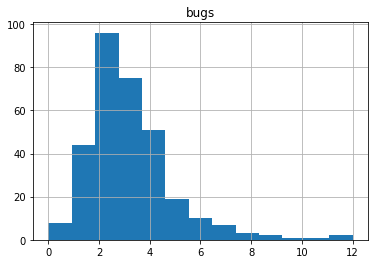

In [198]:
df.hist('bugs', bins=13)

Целевой признак `bugs` в интервале от 0 до 12. Распределение близко к распределению Пуассона. Нет отрицательных и явно ошибочных значений.

In [6]:
df['commit_author'].value_counts()

Victor     134
Mallory     67
Wendy       48
Dabe        42
Eve          9
Trudy        9
Carol        4
Bob          2
Peggy        2
Alice        2
Name: commit_author, dtype: int64

Почти половина коммитов сделаны автором Victor. Около 90% коммитов сделаны четырьмя авторами.

In [8]:
df['repository_name'].value_counts()

conductor    114
sensor       102
mlm           41
standard      29
dockers       19
agent         14
Name: repository_name, dtype: int64

Около 70% коммитов в репозиториях `conductor` и `sensor`

In [11]:
df['commit_message'].value_counts()

Merge branch 'changes-to-merge' into 'master'                         4
Initial commit                                                        3
Update service.py                                                     2
Merge branch 'master' of                                              2
installer changes                                                     2
moved config files to /opt/avssoft/configs                            2
fix set_state                                                         2
v2, head/tail problem solved                                          1
забекс устанавливаем отдельно                                         1
install filebeat from offisial repository                             1
added .gitignore                                                      1
More flexible removing of extension in compose files                  1
bug fixes                                                             1
suricata pcaplog enabling                                       

Признак `commit_message` содержит текст на русском или английском языках. Объекты почти не повторяются.

Изменяю формат признака `commit_date` на `DateTime`

In [115]:
df['commit_date'] = pd.to_datetime(df['commit_date'])

In [116]:
df['commit_date'].describe()

count                     319
unique                    318
top       2020-06-10 10:17:03
freq                        2
first     2020-03-08 14:26:16
last      2020-06-12 14:26:12
Name: commit_date, dtype: object

Датасет состоит из записей в промежутке времени с `2020-03-08 14:26:16` до `2020-06-12 14:26:12`

Добавление новых признаков со значениями дня недели и часа.

In [43]:
df['dayofweek'] = df['commit_date'].dt.weekday
df['hour'] = pd.DatetimeIndex(df['commit_date']).hour

Создаю новый датафрейм `df_sort`, отсортированный по дате по возрастанию

In [45]:
df_sort = df.sort_values('commit_date')

In [74]:
df_sort.head()

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs,dayofweek,hour
40,mlm,79db41fb,2020-03-08 14:26:16,Victor,Initial commit,3,6,14
39,mlm,bfa1152f,2020-03-08 15:38:30,Victor,JsonMaster as function separator,6,6,15
38,mlm,29ba5151,2020-03-08 17:18:35,Victor,Small Fixes in models.py to make it work,12,6,17
37,mlm,a8b55539,2020-03-08 17:19:19,Victor,Added .gitignore,3,6,17
36,mlm,bb54e4e6,2020-03-08 17:23:12,Victor,Small Fixes in main.py to make it work,12,6,17


Создаю обучающую и тестовую выборки в соотношении 80:20. Предварительно удаляю признаки `commit_hash` и `commit_date`. Значение `commit_hash` уникальны и не нужны для обучения модели.

In [46]:
X = df_sort.drop(['commit_hash', 'commit_date', 'bugs'], axis=1)
y = df_sort['bugs']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

Создаю список категориальных признаков

In [47]:
categorical_cols = ['repository_name', 'commit_author', 'dayofweek', 'hour']

OneHotEncoding категориальных признаков

In [51]:
encoder = OneHotEncoder(handle_unknown = 'ignore')
X_train_cat = encoder.fit_transform(X_train[categorical_cols])
X_test_cat = encoder.transform(X_test[categorical_cols])

Загрузка списка стоп-слов на русском и английском языках

In [49]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words(['english', 'russian']))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Расчёт TF-IDF для признака `commit_message`, который содержит текст

In [50]:
vect_word = TfidfVectorizer(ngram_range=(1,2),
               min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words=stopwords)

In [52]:
train_tfidf = vect_word.fit_transform(X_train['commit_message'])
test_tfidf = vect_word.transform(X_test['commit_message'])

Создание списка с названиями всех признаков

In [94]:
column_names_from_text = vect_word.vocabulary_
dictionary = {v:k for k,v in vect_word.vocabulary_.items()}
column_names_from_text = [v for k,v in dictionary.items()]
cat_column_names = list(encoder.get_feature_names())
all_columns = column_names_from_text + cat_column_names

Объединение разреженных матриц для обучающей и тестовой выборок. Проверка размерности

In [56]:
X_train_prod = hstack([train_tfidf, X_train_cat])
print(X_train_prod.shape)

(255, 120)


In [57]:
X_test_prod = hstack([test_tfidf, X_test_cat])
print(X_test_prod.shape)

(64, 120)


### Обучение и тестирование моделей

Поиск гиперпарметров будет осуществляться с помощью GridSearchCV с кросс-валидацией на 3 подвыборках

In [58]:
kf = KFold(n_splits=3, shuffle=False)

#### Линейная регрессия

In [75]:
parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
grid_lr = GridSearchCV(LinearRegression(), parameters, cv=kf, scoring='neg_mean_squared_error')
grid_lr.fit(X_train_prod, y_train)
params = grid_lr.best_params_
print('RMSE на кросс-валидации: ', abs(grid_lr.best_score_) ** 0.5)
lr = LinearRegression(**params)
lr.fit(X_train_prod, y_train)
pred_test = lr.predict(X_test_prod)
print(params)
print("RMSE на тестовой выборке: ", mean_squared_error(y_test, pred_test) ** 0.5)

RMSE на кросс-валидации:  3.2343726672152338
{'fit_intercept': True, 'normalize': False}
RMSE на тестовой выборке:  3.0135443305620435


#### Support Vector Regression

In [76]:
param_svr = {'kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),
             'C' : [0.01, 0.1, 1, 10, 100],
             'coef0' : [0.25, 0.5, 1, 10],
             'gamma' : ('auto','scale')},

grid_svr = GridSearchCV(SVR(), param_svr, refit=False, cv=kf, scoring='neg_mean_squared_error') 
grid_svr.fit(X_train_prod, y_train)
print('RMSE на кросс-валидации: ', abs(grid_svr.best_score_) ** 0.5)
params = grid_svr.best_params_
svr = SVR(**params)
svr.fit(X_train_prod, y_train)
pred_test = svr.predict(X_test_prod)
print(params)
print("RMSE на тестовой выборке: ", mean_squared_error(y_test, pred_test) ** 0.5)

RMSE на кросс-валидации:  1.8047323412438594
{'C': 0.01, 'coef0': 10, 'gamma': 'auto', 'kernel': 'sigmoid'}
RMSE на тестовой выборке:  2.0441991096704086


#### Случайный лес

Для RandomForestRegressor поиск будет осуществляться по гиперпараметрам `max_depth`, `min_samples_split`. Создаю переменную `tree_params` c различными вариантами значений указанных гиперпараметров.

In [77]:
tree_params = {'n_estimators': [1000], 
               'max_depth': [2, 4, 6, None],
               'min_samples_split': [2, 5, 8, 10]}

grid_rfr = GridSearchCV(RandomForestRegressor(random_state=SEED), 
                        tree_params, refit=False, cv=kf, scoring='neg_mean_squared_error') 
grid_rfr.fit(X_train_prod, y_train)
print('RMSE на кросс-валидации: ', abs(grid_rfr.best_score_) ** 0.5)
params = grid_rfr.best_params_
rfr = RandomForestRegressor(**params, random_state=SEED)
rfr.fit(X_train_prod, y_train)
pred_test = rfr.predict(X_test_prod)
print(params)
print("RMSE на тестовой выборке: ", mean_squared_error(y_test, pred_test) ** 0.5)

RMSE на кросс-валидации:  1.8888070434641084
{'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 1000}
RMSE на тестовой выборке:  1.8690051371718777


#### CatBoost

Для CatBoostRegressor поиск будет осуществляться по гиперпараметрам `learning_rate` и `depth`. Создаю переменную `param_grid_ctb` c различными вариантами значений указанных гиперпараметров

In [81]:
param_grid_ctb = {'n_estimators': [1000],  
                  'learning_rate': [0.01, 0.03, 0.1, 0.2],
                  'depth': [2, 4, 6, 8]}

grid_ctb = GridSearchCV(CatBoostRegressor(random_state=SEED, silent=True), 
                    param_grid_ctb, cv=kf, scoring='neg_mean_squared_error', refit=False) 
grid_ctb.fit(X_train_prod, y_train)
print('RMSE на кросс-валидации: ', abs(grid_ctb.best_score_) ** 0.5)
params = grid_ctb.best_params_
ctb = CatBoostRegressor(**params, random_state=SEED, silent=True)
ctb.fit(X_train_prod, y_train)
pred_test = ctb.predict(X_test_prod)
print(params)
print("RMSE на тестовой выборке: ", mean_squared_error(y_test, pred_test) ** 0.5)

RMSE на кросс-валидации:  1.937238766968832
{'depth': 8, 'learning_rate': 0.01, 'n_estimators': 1000}
RMSE на тестовой выборке:  1.8617684844917837


#### LightGBM

Для LGBMRegressor поиск будет осуществляться по гиперпараметрам `learning_rate` и `max_depth`. Создаю переменную `param_grid` c различными вариантами значений указанных гиперпараметров.

In [84]:
param_grid = {'n_estimators': [1000], 
              'learning_rate': [0.01, 0.03, 0.1, 0.2],
              'max_depth': [2, 4, 6, 8]}

grid_lgbm = GridSearchCV(lgb.LGBMRegressor(random_state=SEED), 
                    param_grid, cv=kf, scoring='neg_mean_squared_error', refit=False) 
grid_lgbm.fit(X_train_prod, y_train)
print('RMSE на кросс-валидации: ', abs(grid_lgbm.best_score_) ** 0.5)
params = grid_lgbm.best_params_
lgbm = lgb.LGBMRegressor(**params, random_state=SEED)
lgbm.fit(X_train_prod, y_train)
pred_test = lgbm.predict(X_test_prod)
print(params)
print("RMSE на тестовой выборке: ", mean_squared_error(y_test, pred_test) ** 0.5)

RMSE на кросс-валидации:  2.035181627383503
{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 1000}
RMSE на тестовой выборке:  1.8542351321682635


Значимость признаков для лучшей модели LGBMRegressor

In [85]:
eli5.explain_weights_lightgbm(lgbm, feature_names=all_columns, top=10)

Weight,Feature
0.3015,x0_sensor
0.2619,x1_Victor
0.0990,x2_4
0.0810,x1_Dabe
0.0663,commit
0.0630,x1_Mallory
0.0397,x3_17
0.0235,x2_2
0.0197,x0_standard
0.0109,x2_0


# Отчёт
#### 1) Датасет
На этапе предобработки данных были добавлены признаки со значениями дня недели и часа, произведен расчет TF-IDF для текста, произведен OneHotEncoding категориальных признаков.

- Итоговый датасет состоит из 121 признака и 319 строк.
- Временной интервал c 2020-03-08 14:26:16 до 2020-06-12 14:26:12
- Обучающая и тестовая выборка в соотношении 80:20 - 255 и 64 строки.
- 81 признаков - TF-IDF для текста
- 9 признаков - авторы коммита
- 6 признаков - название репозитория
- 7 признаков - дни недели
- 17 признаков - часы
- 1 целевой признак - количество bugs

##### Представленный датасет содержит очень мало данных. Это оказывает негативное влияние на эффективность работы моделей с новыми данными.

#### 2) Модели
- Обучены пять моделей. Результаты RMSE на тестовой выборке: LGBMRegressor - 1.85, CatBoostRegressor - 1.86, RandomForestRegressor - 1.87, SVR - 2, LinearRegression - 3.
- На тестовой выборке лучшего значения RMSE 1.85 удалось достичь используя модель LGBMRegressor с гиперпараметрами 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 1000}
- Наиболее значимые признаки для лучшей модели: название резозитория `sensor` - 30%, автор коммита `Victor` - 26%

#### Графики

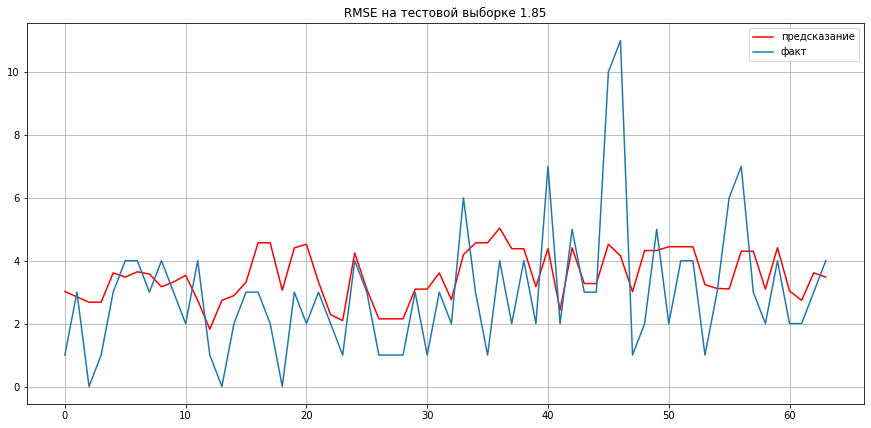

In [87]:
plt.figure(figsize=(15, 7))
plt.plot(pred_test, "r", label="предсказание")
plt.plot(y_test.values, label="факт")
plt.legend(loc="best")
plt.title("RMSE на тестовой выборке {}".format(round(mean_squared_error(pred_test, y_test) ** 0.5, 2)))
plt.grid(True);

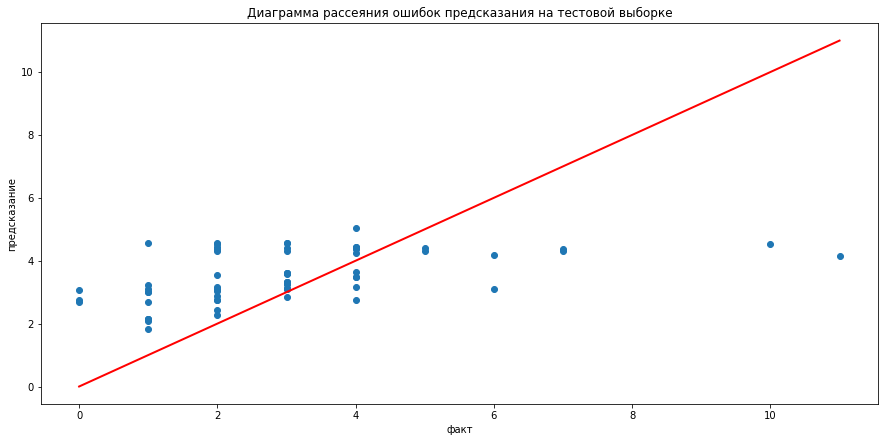

In [88]:
y = y_test.values
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(y, pred_test)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r', lw=2)
ax.set_xlabel('факт')
ax.set_ylabel('предсказание')
ax.set_title('Диаграмма рассеяния ошибок предсказания на тестовой выборке')
plt.show()